(6402, 60) (6402,)
(1601, 60) (1601,)
(6402, 60, 1) (1601, 60, 1)
(6402, 60, 1) (1601, 60, 1)
(60, 1)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60, 1)]      0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 60, 1)       2           ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 60, 1)       19321       ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0

 tf.__operators__.add_6 (TFOpLa  (None, 60, 1)       0           ['dropout_6[0][0]',              
 mbda)                                                            'tf.__operators__.add_5[0][0]'] 
                                                                                                  
 layer_normalization_7 (LayerNo  (None, 60, 1)       2           ['tf.__operators__.add_6[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv1d_6 (Conv1D)              (None, 60, 55)       110         ['layer_normalization_7[0][0]']  
                                                                                                  
 dropout_7 (Dropout)            (None, 60, 55)       0           ['conv1d_6[0][0]']               
                                                                                                  
 conv1d_7 

Epoch 18/30
257/257 [==============================] - 17s 65ms/step - loss: 69.3615 - mean_squared_error: 69.3615 - val_loss: 24.5903 - val_mean_squared_error: 24.5903 - lr: 5.6710e-04
Epoch 19/30
257/257 [==============================] - 17s 67ms/step - loss: 67.3993 - mean_squared_error: 67.3993 - val_loss: 18.6468 - val_mean_squared_error: 18.6468 - lr: 6.0040e-04
Epoch 20/30
257/257 [==============================] - 21s 81ms/step - loss: 67.6786 - mean_squared_error: 67.6786 - val_loss: 18.4103 - val_mean_squared_error: 18.4103 - lr: 6.3370e-04
Epoch 21/30
257/257 [==============================] - 22s 85ms/step - loss: 61.8233 - mean_squared_error: 61.8233 - val_loss: 31.6246 - val_mean_squared_error: 31.6246 - lr: 6.6700e-04
Epoch 22/30
257/257 [==============================] - 21s 84ms/step - loss: 62.0818 - mean_squared_error: 62.0818 - val_loss: 19.1173 - val_mean_squared_error: 19.1173 - lr: 7.0030e-04
Epoch 23/30
257/257 [==============================] - 22s 85ms/step -

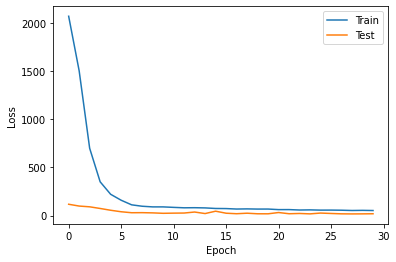

51/51 [==============================] - 2s 29ms/step
Accuracy score of the predictions: 0.6449071432183355


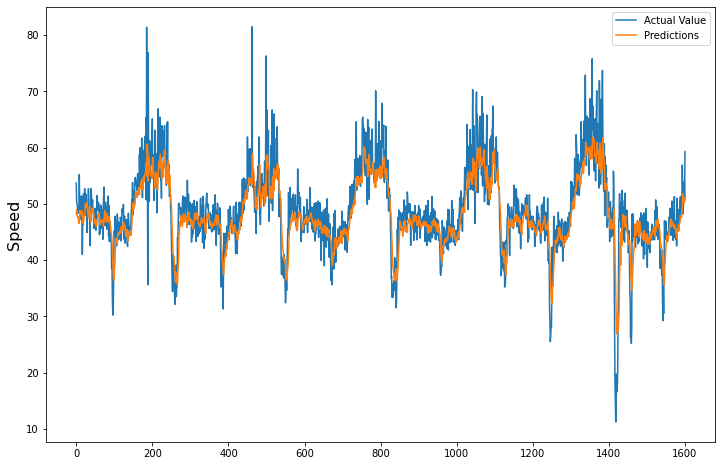

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import pandas as pd
import numpy as np
df = pd.read_csv('./input/daejeon_vds16.csv')
df.head()
df.set_index('Date', inplace=True)

spd=df.reset_index()['Speed']
windows = 60
X, y = [], []
for i in range(len(spd)-windows-1):
    X.append(spd[i:(i+windows)])
    y.append(spd[(i+windows)])

X = np.array(X)
y = np.array(y)
X.shape
X[:3]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.20, shuffle=False)
print(X_train.shape, y_train.shape)
print(X_test.shape,  y_test.shape)

X_train = np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = np.array(X_test).reshape(X_test.shape[0], X_test.shape[1], 1)
print(X_train.shape, X_test.shape)

X_train_ = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test_ = X_test.reshape(X_test.shape[0],X_test.shape[1],1)
print(X_train_.shape, X_test_.shape) 

### G. Transformer 모델을 적용해보자
from keras import backend as K
from tensorflow import keras
from tensorflow.keras import layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):    
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, 
                                  dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs   
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation = "relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, 
                mlp_units, dropout=0, mlp_dropout=0):
    
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):  # This is what stacks our transformer blocks
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="elu")(x)
        x = layers.Dropout(mlp_dropout)(x)
        
    outputs = layers.Dense(1, activation="linear")(x) #this is a pass-through
    return keras.Model(inputs, outputs)

def lr_scheduler(epoch, lr, warmup_epochs=30, decay_epochs=100, 
                 initial_lr=1e-6, base_lr=1e-3, min_lr=5e-5):
    if epoch <= warmup_epochs:
        pct = epoch / warmup_epochs
        return ((base_lr - initial_lr) * pct) + initial_lr

    if epoch > warmup_epochs and epoch < warmup_epochs+decay_epochs:
        pct = 1 - ((epoch - warmup_epochs) / decay_epochs)
        return ((base_lr - min_lr) * pct) + min_lr

    return min_lr

callbacks = [ tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
            tf.keras.callbacks.LearningRateScheduler(lr_scheduler)      ]

input_shape = X_train_.shape[1:]
print(input_shape)
model = build_model(input_shape, head_size=46,  num_heads=60,  ff_dim=55,  
                    num_transformer_blocks=5, mlp_units=[64], mlp_dropout=0.4, dropout=0.14, )
model.compile( loss="mean_squared_error",
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=["mean_squared_error"])
model.summary()
history = model.fit( X_train_, y_train, validation_split=0.2, epochs=30, batch_size=20, callbacks=callbacks)

import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

y_pred = model.predict(X_test_)
pred_df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
pred_df.head()
Acc=[]
from sklearn.metrics import r2_score
print("Accuracy score of the predictions: {0}".format(r2_score(y_test, y_pred)))
Acc.append(r2_score(y_test, y_pred))
plt.figure(figsize=(12,8))
plt.ylabel('Speed', fontsize=16)
plt.plot(pred_df)
plt.legend(['Actual Value', 'Predictions'])
plt.show()

## 머신러닝의 러닝커브를 위한 함수를 정의하자

## (#) Deep Neural Network
- MLP와 ReLu를 활용한 신경망을 사용하자

# 5. 머신러닝 모델을 만들자

# (1) 연습문제 해보기 : 속도
- VDS 데이터의 라벨을 속도(Speed)에 대하여 자신의 라벨을 정의하시오
- 예 (20, 50) 등 
- 훈련(Train)과 시험(Test)의 정확도 혹은 손실(Loss)를 제출하시오

# (2) 연습문제 해보기 : 교통량
### 교통량(ToVol) 혹은 SmVol로 라벨을 정하는 방법을 적용하세요
- 예 (100, 300) 등 
- 훈련(Train)과 시험(Test)의 정확도 혹은 손실(Loss)를 제출하시오

# (3) 연습문제 해보기
- VDS 데이터의 라벨을 점유률(Occ.Rate)에 대하여 자신의 라벨을 정의하시오
- 예 (8, 16) 등 
- 훈련(Train)과 시험(Test)의 정확도 혹은 손실(Loss)를 제출하시오

# (4) 연습문제 해보기
- 머신러닝 방법과 DNN 방법을 비교하여 자장 휼룡한 신경망 방법과 하이퍼파라미터를 설정하세요.